In [22]:
import time
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)

import torch
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.io import load_obj
from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)
from pytorch3d.renderer.blending import BlendParams
from pytorch3d.renderer import TexturesVertex
from src.render.points_renderer import PointsRenderer
from src.render.pulsar_renderer import PulsarRenderer
from src.config import get_parser
from src.blueprint_sampler import BlueprintSampler
from src.util import grid_to_list

In [16]:
# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)

bs = 1
    
config = get_parser().parse_args(args=[])

config.raster_image_size = 1024
config.data_blueprint = 'blueprint_radial_1024.npz'
config.data_blueprint_size = 1024
config.data_patch_size = 512
blueprintSampler = BlueprintSampler(config)
res = blueprintSampler(bs)
points = res['points']
normals = res['normals']
faces = res['faces']

points = grid_to_list(points).to(device)
normals = grid_to_list(normals).to(device)
#faces = faces.to(device)

points.shape, normals.shape, faces.shape

(torch.Size([1, 262144, 3]),
 torch.Size([1, 262144, 3]),
 torch.Size([1, 522242, 3]))

In [17]:
R = PointsRenderer(config)
R.setup(device)
R = R.to(device)

0.23126983642578125


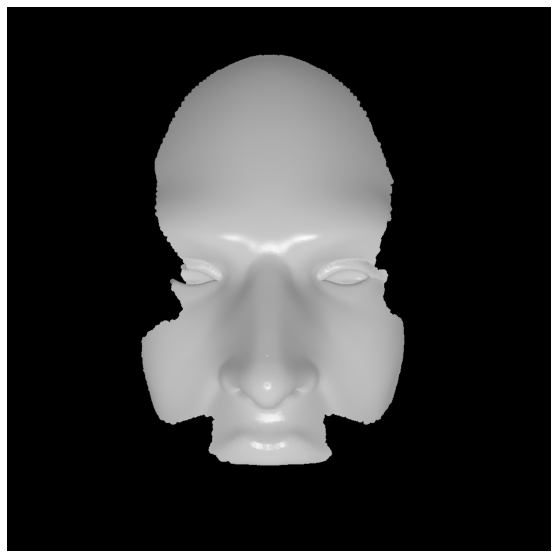

In [18]:
start_time = time.time()
images = R(points, normals=normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

tensor([[[ 0.0000,  0.0000,  0.0000],
         [-0.2195,  0.2118,  0.9523],
         [-0.7993, -0.5982,  0.0571],
         ...,
         [ 0.9913,  0.0713,  0.1105],
         [ 0.9914,  0.0722,  0.1088],
         [ 0.9912,  0.0768,  0.1081]]], device='cuda:0')

0.23614192008972168


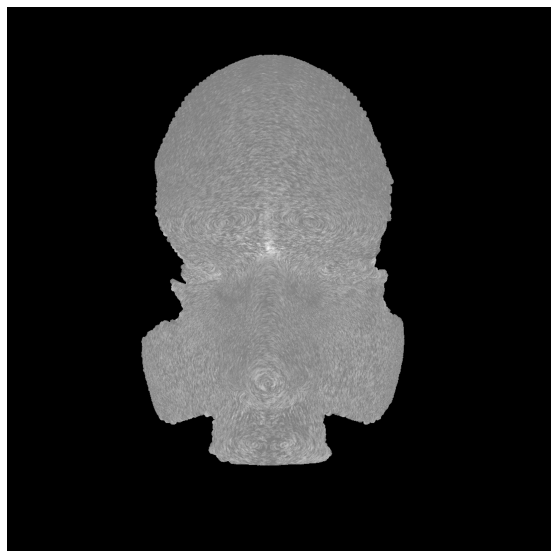

In [19]:
cal_normals = R.get_vertex_normals(points)
cal_normals

start_time = time.time()
images = R(points, normals=cal_normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

0.23780441284179688


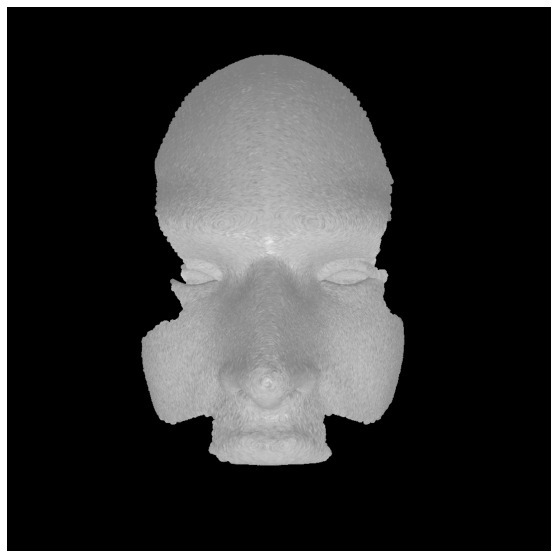

In [28]:
int_normals = F.normalize(cal_normals *0.4 + normals* 0.6 , p=2, dim=1)
int_normals.shape

start_time = time.time()
images = R(points, normals=int_normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

<ipython-input-30-8bcb7c0443ff>:10: UserWarning:

The following kwargs were not used by contour: 'lw'

<ipython-input-30-8bcb7c0443ff>:11: UserWarning:

The following kwargs were not used by contour: 'lw'



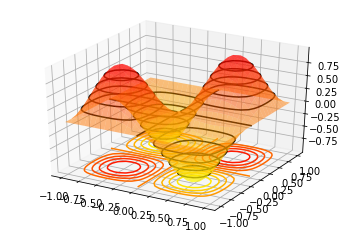

In [30]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, Y = np.mgrid[-1:1:30j, -1:1:30j]
Z = np.sin(np.pi*X)*np.sin(np.pi*Y)
ax.plot_surface(X, Y, Z, cmap="autumn_r", lw=0.5, rstride=1, cstride=1, alpha=0.5)
ax.contour(X, Y, Z, 10, lw=3, cmap="autumn_r", linestyles="solid", offset=-1)
ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
plt.show();

In [31]:
X.shape, Y.shape

((30, 30), (30, 30))

In [36]:
a = F.normalize(torch.arange(60.).reshape(3, 4, 5), dim
b = torch.arange(24.).reshape(4, 3, 2)
print(torch.tensordot(a, b, dims=([1, 0], [0, 1])))
torch.tensordot(a, b, dims=([1, 0], [0, 1])).shape

tensor([[4400., 4730.],
        [4532., 4874.],
        [4664., 5018.],
        [4796., 5162.],
        [4928., 5306.]])


torch.Size([5, 2])

In [37]:
cal_normals.shape,  normals.shape

(torch.Size([1, 262144, 3]), torch.Size([1, 262144, 3]))

In [39]:
torch.tensordot(cal_normals[0], normals[0])

tensor(2708.1907, device='cuda:0')

In [44]:
elm_dot = torch.sum(cal_normals * normals, dim=-1).reshape(512, 512)
elm_dot.shape

torch.Size([512, 512])

In [56]:
elm_dot.shape

torch.Size([512, 512])

<ipython-input-63-3dfc94017337>:6: UserWarning:

The following kwargs were not used by contour: 'lw'

<ipython-input-63-3dfc94017337>:7: UserWarning:

The following kwargs were not used by contour: 'lw'



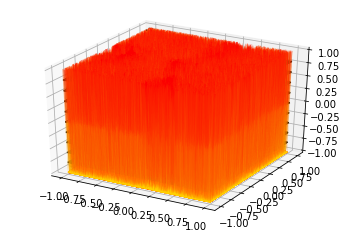

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, Y = np.mgrid[-1:1:512j, -1:1:512j]
Z = elm_dot.cpu().numpy()
ax.plot_surface(X, Y, Z, cmap="autumn_r", lw=0.5, rstride=1, cstride=1, alpha=0.5)
ax.contour(X, Y, Z, 10, lw=3, cmap="autumn_r", linestyles="solid", offset=-1)
ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
plt.show();

In [69]:
(elm_dot < 0.5).sum() / elm_dot.numel()

tensor(0.6744, device='cuda:0')

In [52]:
torch.arange(512).shape

torch.Size([512])

In [55]:
torch.meshgrid(torch.arange(512),torch.arange(512))[0].shape

torch.Size([512, 512])

In [60]:
X, Y = np.mgrid[-1:1:512j, -1:1:512j]
X.shape, Y.shape

((512, 512), (512, 512))

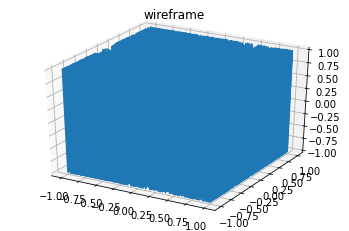

In [71]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z)
ax.set_title('wireframe');

ValueError: x and y must be equal-length 1-D arrays

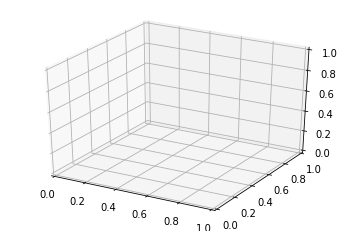

In [72]:
ax = plt.axes(projection='3d')
ax.plot_trisurf(X, Y, Z,
                cmap='viridis', edgecolor='none');